In [1]:
%load_ext lab_black

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy.stats.stats import pearsonr
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate

from pprint import pprint

In [3]:
def cross_validate_report(model, X, y, show=True, return_coef=False):
    scoring = ["neg_mean_squared_error", "neg_root_mean_squared_error"]

    result = cross_validate(model, X, y, scoring=scoring, return_estimator=True)

    coef_estimates = [list(estimator.coef_) for estimator in result["estimator"]]

    cv_test_mse = -result["test_neg_mean_squared_error"].mean()
    cv_test_rmse = -result["test_neg_root_mean_squared_error"].mean()

    if show:
        print("Test Metrics")
        print(f"CV Test MSE: {cv_test_mse}")
        print(f"CV Test RMSE: {cv_test_rmse}")
        print()
        print(f"Coefficient Estimates Across Folds: ")
        pprint(coef_estimates)

    if return_coef:
        return coef_estimates

In [4]:
SEED = 1232
N_OBS = 10_000

In [5]:
np.random.seed(SEED)

In [6]:
x_1 = np.random.uniform(0, 10, N_OBS)
e = np.random.normal(0, 1, N_OBS)
y = 3 + 2 * x_1 + e
X_1 = x_1.reshape(-1, 1)

In [7]:
cross_validate_report(LinearRegression(), X_1, y)

Test Metrics
CV Test MSE: 0.9976868485897763
CV Test RMSE: 0.9986361850659733

Coefficient Estimates Across Folds: 
[[2.003916504815428],
 [1.999360739873484],
 [2.0022054580572983],
 [2.002643045098601],
 [1.997803728371471]]


In [8]:
g = np.random.normal(0, 0.02, N_OBS)
x_2 = -x_1 + g
X_2 = x_2.reshape(-1, 1)

In [9]:
r, _ = pearsonr(x_1, x_2)
print(r)

-0.9999763618212614


In [10]:
cross_validate_report(LinearRegression(), X_2, y)

Test Metrics
CV Test MSE: 0.999251622173378
CV Test RMSE: 0.9994287523796187

Coefficient Estimates Across Folds: 
[[-2.003950093657345],
 [-1.9993568555858896],
 [-2.0019507942016554],
 [-2.002570445670684],
 [-1.9976575145905358]]


In [11]:
X = np.concatenate((X_1, X_2), axis=1)

In [12]:
cross_validate_report(LinearRegression(), X, y)

Test Metrics
CV Test MSE: 0.9979789014383658
CV Test RMSE: 0.998782820506453

Coefficient Estimates Across Folds: 
[[2.162196563423683, 0.1582907346858038],
 [1.7455118735736175, -0.2538589115804198],
 [1.8375370239161435, -0.1646546371137125],
 [2.482849308363655, 0.48021684530968234],
 [1.7367885620817711, -0.2610068478133601]]


In [13]:
cross_validate_report(LassoCV(), X, y)

Test Metrics
CV Test MSE: 0.997719657693275
CV Test RMSE: 0.9986556274421525

Coefficient Estimates Across Folds: 
[[2.001912588310612, -0.0],
 [1.9973493876757304, -2.3983294588933922e-05],
 [2.000195120687073, -1.591099100072113e-05],
 [2.0006404020535014, -0.0],
 [1.9957933792306792, -2.4937281229812884e-05]]


In [14]:
%%time
data = []

for gamma_std in np.linspace(0.005, 0.1):
    g = np.random.normal(0, gamma_std, N_OBS)
    x_2 = -x_1 + g
    X_2 = x_2.reshape(-1, 1)
    X = np.concatenate((X_1, X_2), axis=1)

    r, _ = pearsonr(x_1, x_2)

    lr_coefs_across_folds = cross_validate_report(
        LinearRegression(), X, y, show=False, return_coef=True
    )

    lasso_coefs_across_folds = cross_validate_report(
        LassoCV(max_iter=3_000), X, y, show=False, return_coef=True
    )

    for lr_coefs_fold, lasso_coefs in zip(
        lr_coefs_across_folds, lasso_coefs_across_folds
    ):
        lr_beta_1 = lr_coefs_fold[0]
        lr_beta_2 = lr_coefs_fold[1]
        lasso_beta_1 = lasso_coefs[0]
        lasso_beta_2 = lasso_coefs[1]
        data.append(
            {
                "gamma_std": gamma_std,
                "r": r,
                "lr_beta_1": lr_beta_1,
                "lr_beta_2": lr_beta_2,
                "lasso_beta_1": lasso_beta_1,
                "lasso_beta_2": lasso_beta_2,
            }
        )

plot_df = pd.DataFrame(data)

CPU times: user 20.5 s, sys: 7.56 ms, total: 20.5 s
Wall time: 21.3 s


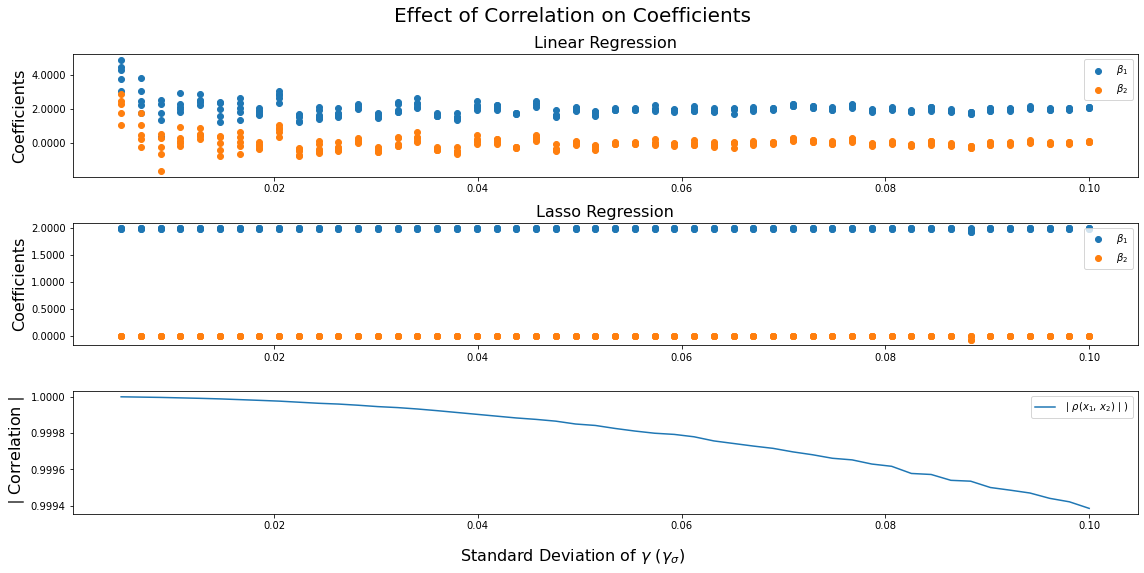

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 8))

lr_coef_plot = axes[0]
lasso_coef_plot = axes[1]
corr_plot = axes[2]

lr_coef_plot.scatter(plot_df["gamma_std"], plot_df["lr_beta_1"], label=r"$\beta_{1}$")
lr_coef_plot.scatter(plot_df["gamma_std"], plot_df["lr_beta_2"], label=r"$\beta_{2}$")
lr_coef_plot.legend(loc="upper right")
lr_coef_plot.yaxis.set_major_formatter("{x:.4f}")
lr_coef_plot.set_title("Linear Regression", size=16)
lr_coef_plot.set_ylabel(r"Coefficients", size=16)

lasso_coef_plot.scatter(
    plot_df["gamma_std"], plot_df["lasso_beta_1"], label=r"$\beta_{1}$"
)
lasso_coef_plot.scatter(
    plot_df["gamma_std"], plot_df["lasso_beta_2"], label=r"$\beta_{2}$"
)
lasso_coef_plot.legend(loc="upper right")
lasso_coef_plot.yaxis.set_major_formatter("{x:.4f}")
lasso_coef_plot.set_title("Lasso Regression", size=16)
lasso_coef_plot.set_ylabel(r"Coefficients", size=16)

corr_plot.plot(
    plot_df["gamma_std"],
    plot_df["r"].abs(),
    label=r"$\mid\rho(x_{1},\,x_{2})\mid$)",
)
corr_plot
corr_plot.legend(loc="upper right")
corr_plot.yaxis.set_major_formatter("{x:.4f}")
corr_plot.set_ylabel(r"$\mid$Correlation$\mid$", size=16)

fig.suptitle("Effect of Correlation on Coefficients", size=20)
fig.supxlabel(r"Standard Deviation of $\gamma$ ($\gamma_{\sigma}$)", size=16)

plt.tight_layout()
plt.savefig("../static/synthetic_coef.png")
plt.show()